In [1]:
!pip install -q \
  torch torchaudio \
  transformers \
  soundfile \
  librosa \
  numpy scipy \
  scikit-learn \
  umap-learn \
  matplotlib seaborn \
  tqdm


In [2]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/Liquidity_Research/experiments/vctk_mic2_16k_v1


audio_16k  manifest  preprocessing_log.json  stats


In [4]:
from google.colab import userdata
hf_token = userdata.get("HF_TOKEN")


In [5]:
from huggingface_hub import login
login(token=hf_token)


In [6]:
from transformers import HubertModel
HubertModel.from_pretrained("facebook/hubert-base-ls960")


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

HubertModel(
  (feature_extractor): HubertFeatureEncoder(
    (conv_layers): ModuleList(
      (0): HubertGroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): HubertFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): HubertEncoder(
    (pos_conv_embed): HubertPositionalConvEmbedding(
      (conv): Para

In [7]:
ROOT = "/content/drive/MyDrive/Liquidity_Research/experiments/vctk_mic2_16k_v1"

AUDIO_ROOT  = f"{ROOT}/audio_16k"
HUBERT_ROOT = f"{ROOT}/hubert_feats"
STATS_ROOT  = f"{ROOT}/stats"

import os
os.makedirs(HUBERT_ROOT, exist_ok=True)


In [8]:
import torch
import soundfile as sf
import numpy as np
from tqdm import tqdm
from transformers import HubertModel

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = HubertModel.from_pretrained("facebook/hubert-base-ls960")
model.eval().to(DEVICE)

with torch.no_grad():
    for spk in sorted(os.listdir(AUDIO_ROOT)):
        spk_path = os.path.join(AUDIO_ROOT, spk)
        if not os.path.isdir(spk_path):
            continue

        out_spk = os.path.join(HUBERT_ROOT, spk)
        os.makedirs(out_spk, exist_ok=True)

        wavs = [f for f in os.listdir(spk_path) if f.endswith(".wav")]

        for w in tqdm(wavs, desc=f"HuBERT {spk}"):
            out_path = os.path.join(out_spk, w.replace(".wav", ".npy"))
            if os.path.exists(out_path):
                continue

            audio, sr = sf.read(os.path.join(spk_path, w))
            audio = audio.astype(np.float32)

            if audio.ndim > 1:
                audio = audio.mean(axis=1)

            x = torch.from_numpy(audio).unsqueeze(0).to(DEVICE)

            feats = model(x).last_hidden_state.squeeze(0)
            feats = feats.cpu().numpy().astype(np.float32)

            np.save(out_path, feats)


HuBERT s5: 100%|██████████| 398/398 [00:24<00:00, 16.38it/s]


In [9]:
import librosa
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_raw, y = [], []

for spk in os.listdir(AUDIO_ROOT):
    spk_path = os.path.join(AUDIO_ROOT, spk)
    for w in os.listdir(spk_path)[:50]:  # cap per speaker
        if not w.endswith(".wav"): continue
        audio, sr = sf.read(os.path.join(spk_path, w))
        audio = audio.astype(np.float32)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        X_raw.append(mfcc.mean(axis=1))
        y.append(spk)

X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.3)
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
print("Speaker accuracy (raw MFCC):", accuracy_score(y_test, clf.predict(X_test)))


Speaker accuracy (raw MFCC): 0.7743119266055046


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_hubert, y = [], []

for spk in os.listdir(HUBERT_ROOT):
    spk_path = os.path.join(HUBERT_ROOT, spk)
    for f in os.listdir(spk_path)[:50]:  # same cap
        if not f.endswith(".npy"):
            continue
        feats = np.load(os.path.join(spk_path, f))
        X_hubert.append(feats.mean(axis=0))  # mean over time
        y.append(spk)

X_train, X_test, y_train, y_test = train_test_split(
    X_hubert, y, test_size=0.3, random_state=42
)

clf = LogisticRegression(max_iter=2000, n_jobs=-1)
clf.fit(X_train, y_train)

acc = accuracy_score(y_test, clf.predict(X_test))
print("Speaker accuracy (HuBERT):", acc)


Speaker accuracy (HuBERT): 0.909480122324159


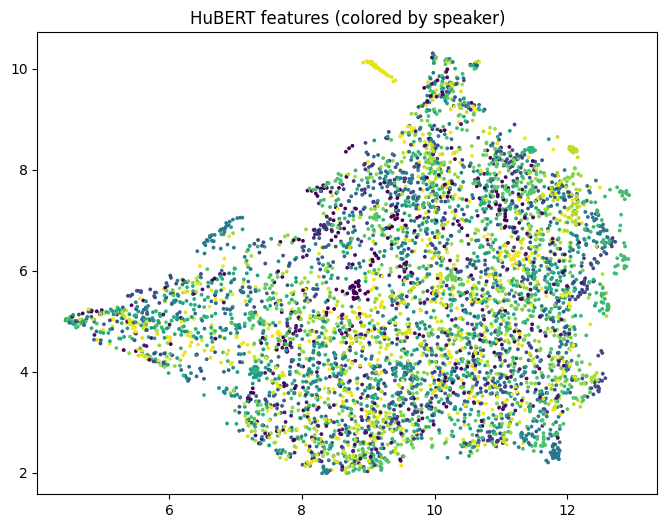

In [12]:
import umap
import matplotlib.pyplot as plt

emb = np.array(X_hubert)
labels = np.array(y)

proj = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(emb)

plt.figure(figsize=(8,6))
plt.scatter(proj[:,0], proj[:,1], c=[hash(l)%50 for l in labels], s=3)
plt.title("HuBERT features (colored by speaker)")
plt.show()


In [13]:
import os
import numpy as np
from tqdm import tqdm
import random

HUBERT_ROOT = "/content/drive/MyDrive/Liquidity_Research/experiments/vctk_mic2_16k_v1/hubert_feats"
KMEANS_ROOT = "/content/drive/MyDrive/Liquidity_Research/experiments/vctk_mic2_16k_v1/kmeans"

os.makedirs(KMEANS_ROOT, exist_ok=True)

MAX_FRAMES = 2_000_000   # ~2M frames is plenty
frames = []

rng = np.random.default_rng(42)

for spk in os.listdir(HUBERT_ROOT):
    spk_path = os.path.join(HUBERT_ROOT, spk)
    files = [f for f in os.listdir(spk_path) if f.endswith(".npy")]
    rng.shuffle(files)

    for f in files[:10]:  # cap per speaker
        feats = np.load(os.path.join(spk_path, f))
        if feats.shape[0] > 0:
            idx = rng.choice(
                feats.shape[0],
                size=min(200, feats.shape[0]),
                replace=False
            )
            frames.append(feats[idx])

        if sum(x.shape[0] for x in frames) >= MAX_FRAMES:
            break
    if sum(x.shape[0] for x in frames) >= MAX_FRAMES:
        break

X = np.concatenate(frames, axis=0)
print("Sampled frames:", X.shape)


Sampled frames: (171633, 768)


In [14]:
mean = X.mean(axis=0)
std  = X.std(axis=0) + 1e-6

Xn = (X - mean) / std

np.save(os.path.join(KMEANS_ROOT, "mean.npy"), mean)
np.save(os.path.join(KMEANS_ROOT, "std.npy"), std)


In [15]:
from sklearn.cluster import MiniBatchKMeans

K = 1000

kmeans = MiniBatchKMeans(
    n_clusters=K,
    batch_size=4096,
    random_state=42,
    verbose=1
)

kmeans.fit(Xn)

centroids = kmeans.cluster_centers_
np.save(os.path.join(KMEANS_ROOT, "centroids.npy"), centroids)


Init 1/1 with method k-means++
Inertia for init 1/1: 4837554.5
[MiniBatchKMeans] Reassigning 117 cluster centers.
Minibatch step 1/4190: mean batch inertia: 399.9575500488281
Minibatch step 2/4190: mean batch inertia: 313.4687805175781, ewa inertia: 313.4687805175781
Minibatch step 3/4190: mean batch inertia: 286.27655029296875, ewa inertia: 312.1709097577054
[MiniBatchKMeans] Reassigning 105 cluster centers.
Minibatch step 4/4190: mean batch inertia: 278.0753173828125, ewa inertia: 310.5435451753084
Minibatch step 5/4190: mean batch inertia: 271.1329040527344, ewa inertia: 308.6624961286386
Minibatch step 6/4190: mean batch inertia: 265.2760009765625, ewa inertia: 306.5916816729608
[MiniBatchKMeans] Reassigning 68 cluster centers.
Minibatch step 7/4190: mean batch inertia: 267.12799072265625, ewa inertia: 304.7081005860847
Minibatch step 8/4190: mean batch inertia: 265.6767272949219, ewa inertia: 302.84515379231885
Minibatch step 9/4190: mean batch inertia: 260.96343994140625, ewa ine

In [16]:
UNITS_ROOT = "/content/drive/MyDrive/Liquidity_Research/experiments/vctk_mic2_16k_v1/units"
os.makedirs(UNITS_ROOT, exist_ok=True)

def collapse_repeats(seq):
    out = [seq[0]]
    for s in seq[1:]:
        if s != out[-1]:
            out.append(s)
    return np.array(out, dtype=np.int64)

for spk in tqdm(os.listdir(HUBERT_ROOT), desc="Assign units"):
    spk_path = os.path.join(HUBERT_ROOT, spk)
    out_spk = os.path.join(UNITS_ROOT, spk)
    os.makedirs(out_spk, exist_ok=True)

    for f in os.listdir(spk_path):
        feats = np.load(os.path.join(spk_path, f))
        feats = (feats - mean) / std

        labels = kmeans.predict(feats)
        units = collapse_repeats(labels)

        np.save(os.path.join(out_spk, f), units)


Assign units: 100%|██████████| 109/109 [37:35<00:00, 20.70s/it]


In [17]:
from collections import Counter

counter = Counter()
for spk in os.listdir(UNITS_ROOT):
    for f in os.listdir(os.path.join(UNITS_ROOT, spk)):
        units = np.load(os.path.join(UNITS_ROOT, spk, f))
        counter.update(units.tolist())

counts = np.array([counter[i] for i in range(K)])
np.save(os.path.join(KMEANS_ROOT, "unit_counts.npy"), counts)
print("Top 10 unit counts:", counts.argsort()[-10:])


Top 10 unit counts: [ 93  13 613 922 287 666 895   1 497 549]


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_units, y = [], []

for spk in os.listdir(UNITS_ROOT):
    spk_path = os.path.join(UNITS_ROOT, spk)
    for f in os.listdir(spk_path)[:50]:
        units = np.load(os.path.join(spk_path, f))
        hist = np.bincount(units, minlength=K)
        X_units.append(hist / hist.sum())
        y.append(spk)

X_train, X_test, y_train, y_test = train_test_split(
    X_units, y, test_size=0.3, random_state=42
)

clf = LogisticRegression(max_iter=2000, n_jobs=-1)
clf.fit(X_train, y_train)

acc = accuracy_score(y_test, clf.predict(X_test))
print("Speaker accuracy (DISCRETE UNITS):", acc)


Speaker accuracy (DISCRETE UNITS): 0.022018348623853212


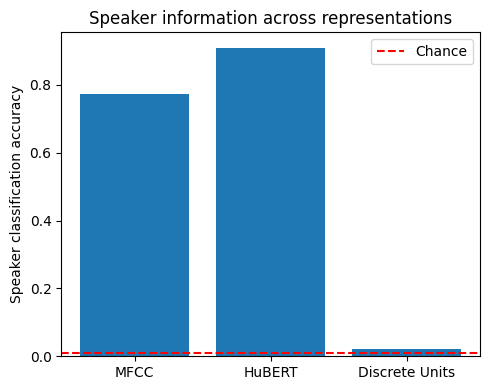

In [20]:
import matplotlib.pyplot as plt

labels = ["MFCC", "HuBERT", "Discrete Units"]
accs = [0.774, 0.909, 0.022]

plt.figure(figsize=(5,4))
plt.bar(labels, accs)
plt.axhline(1/109, linestyle="--", color="red", label="Chance")
plt.ylabel("Speaker classification accuracy")
plt.title("Speaker information across representations")
plt.legend()
plt.tight_layout()
plt.savefig("fig_speaker_probe.png")
plt.show()


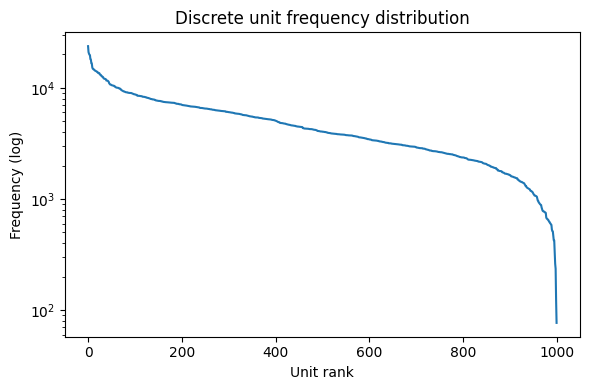

In [23]:
import numpy as np
import matplotlib.pyplot as plt

counts = np.load("/content/drive/MyDrive/Liquidity_Research/experiments/vctk_mic2_16k_v1/kmeans/unit_counts.npy")

plt.figure(figsize=(6,4))
plt.plot(np.sort(counts)[::-1])
plt.yscale("log")
plt.xlabel("Unit rank")
plt.ylabel("Frequency (log)")
plt.title("Discrete unit frequency distribution")
plt.tight_layout()
plt.savefig("fig_unit_frequency.png")
plt.show()


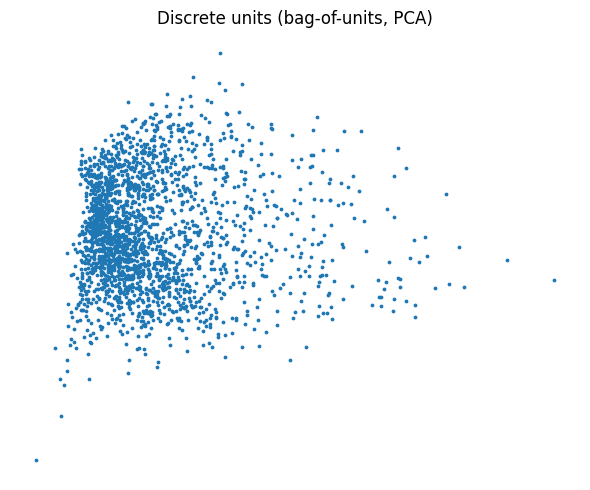

In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

X, y = [], []

for spk in os.listdir(UNITS_ROOT):
    for f in os.listdir(os.path.join(UNITS_ROOT, spk))[:20]:
        u = np.load(os.path.join(UNITS_ROOT, spk, f))
        hist = np.bincount(u, minlength=1000)
        X.append(hist / hist.sum())
        y.append(spk)

X = np.array(X)

X_red = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(X_red[:,0], X_red[:,1], s=3)
plt.title("Discrete units (bag-of-units, PCA)")
plt.axis("off")
plt.tight_layout()
plt.savefig("fig_units_pca.png")
plt.show()


In [ ]:
# Semantic invariance test for discrete HuBERT units
# Same sentence (different speakers) vs random sentence pairs

import os
import numpy as np
import random
from collections import defaultdict

# -------------------------
# CONFIG (EDIT ONLY THIS)
# -------------------------
UNITS_ROOT = "/content/drive/MyDrive/Liquidity_Research/experiments/vctk_mic2_16k_v1/hubert_feats"
MAX_PAIRS = 5000        # cap to keep runtime reasonable
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# -------------------------
# HELPERS
# -------------------------
def unit_distance(u1, u2):
    """Normalized token mismatch rate (length-safe)."""
    L = min(len(u1), len(u2))
    if L == 0:
        return np.nan
    return (u1[:L] != u2[:L]).mean()

# -------------------------
# GROUP BY SENTENCE ID
# -------------------------
sent_groups = defaultdict(list)

for spk in os.listdir(UNITS_ROOT):
    spk_path = os.path.join(UNITS_ROOT, spk)
    if not os.path.isdir(spk_path):
        continue

    for f in os.listdir(spk_path):
        if not f.endswith(".npy"):
            continue

        # Expected format: p225_001.npy → sentence_id = 001
        try:
            sentence_id = f.split("_")[1].split(".")[0]
        except Exception:
            continue

        units = np.load(os.path.join(spk_path, f))
        sent_groups[sentence_id].append(units)

# -------------------------
# SAME-SENTENCE DISTANCES
# -------------------------
same_dist = []

for seqs in sent_groups.values():
    if len(seqs) < 2:
        continue

    for i in range(len(seqs) - 1):
        for j in range(i + 1, len(seqs)):
            same_dist.append(unit_distance(seqs[i], seqs[j]))
            if len(same_dist) >= MAX_PAIRS:
                break
        if len(same_dist) >= MAX_PAIRS:
            break
    if len(same_dist) >= MAX_PAIRS:
        break

# -------------------------
# RANDOM-SENTENCE BASELINE
# -------------------------
all_seqs = [u for seqs in sent_groups.values() for u in seqs]

rand_dist = []
for _ in range(len(same_dist)):
    u1, u2 = random.sample(all_seqs, 2)
    rand_dist.append(unit_distance(u1, u2))

# -------------------------
# RESULTS
# -------------------------
same_mean = np.nanmean(same_dist)
rand_mean = np.nanmean(rand_dist)

print("===== SEMANTIC INVARIANCE RESULTS =====")
print(f"Same sentence (different speakers): {same_mean:.4f}")
print(f"Random sentence pairs           : {rand_mean:.4f}")
print(f"Ratio (same / random)           : {same_mean / rand_mean:.3f}")

# Simple verdict
if same_mean < 0.6 * rand_mean:
    print("✅ PASS: Units preserve linguistic structure across speakers.")
else:
    print("❌ FAIL: Units do not show strong semantic invariance.")
